In [3]:
import matplotlib.pyplot as plt
import numpy as np

def parse_logfile(logfile):
    streams = {}
    with open(logfile, "r") as f:
        for line in f:
            parts = line.split()
            try:
                step = int(parts[0].split(":")[1])
                for part in parts[1:]:
                    stream, val = part.split(":")
                    val = float(val)
                    if stream not in streams:
                        streams[stream] = {}
                    streams[stream][step] = val
            except:
                pass
    streams_xy = {}
    for k, v in streams.items():
        xy = sorted(list(v.items()))
        streams_xy[k] = list(zip(*xy))
    return streams_xy

def plot_logs(files, sz=None, max_steps=None, max_loss=None, max_norm=None):
    xlim = {"left": -10, "right": max_steps} if max_steps else None
    trl_ylim = {"top": max_loss} if max_loss else None
    norm_ylim = {"top": max_norm} if max_norm else None
    alpha = 0.5 if len(files) > 1 else 1.0
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    
    for f, name in files:
        data = parse_logfile(f)
        
        # 1. trl + tel
        ax = axs[0, 0]
        if 'trl' in data:
            ax.plot(data['trl'][0], data['trl'][1], label=f"{name} train loss", alpha=alpha)
            print(f"{name} min train loss: ", min(data["trl"][1]))
        if 'tel' in data:
            ax.plot(data['tel'][0], data['tel'][1], label=f"{name} val loss", alpha=alpha)
            print(f"{name} min val loss: ", min(data["tel"][1]))
        ax.set_title('Training and Validation Loss')
        ax.set_xlabel('Step')
        ax.set_yscale('log')
        ax.grid(True, linestyle='--', color='gray', alpha=0.3)
        if xlim: ax.set_xlim(**xlim)
        ax.autoscale(enable=True, axis='y', tight=False)
        if trl_ylim: ax.set_ylim(**trl_ylim)
        ax.legend(fontsize=6)

        # 2. eval
        #ax = axs[0, 1]
        #if 'eval' in data:
        #    ax.plot(data['eval'][0], data['eval'][1], label=name)
        #    print(f"{name} max HellaSwag: ", max(data["eval"][1]))
        #ax.set_title('HellaSwag')
        #ax.set_xlabel('Step')
        #ax.grid(True, linestyle='--', color='gray', alpha=0.3)
        #if xlim: ax.set_xlim(**xlim)
        #ax.legend(fontsize=6)

        # 3. lr
        ax = axs[1, 0]
        if 'lr' in data:
            ax.plot(data['lr'][0], data['lr'][1], label=name)
        ax.set_title('Learning Rate')
        ax.set_xlabel('Step')
        ax.set_yscale('log')
        ax.grid(True, linestyle='--', color='gray', alpha=0.3)
        if xlim: ax.set_xlim(**xlim)
        ax.legend(fontsize=6)

        # 4. norm
        ax = axs[1, 1]
        if 'norm' in data:
            ax.plot(data['norm'][0], data['norm'][1], label=name, alpha=alpha)
        ax.set_title('Gradient Norm')
        ax.set_xlabel('Step')
        ax.set_yscale('log')
        ax.grid(True, linestyle='--', color='gray', alpha=0.3)
        if xlim: ax.set_xlim(**xlim)
        ax.autoscale(enable=True, axis='y', tight=False)
        if norm_ylim: ax.set_ylim(**norm_ylim)
        ax.legend(fontsize=6)
    
    plt.tight_layout()
    plt.show()

llm.c rook 20k gpt2 124M min train loss:  0.5209
llm.c rook 20k gpt2 124M min val loss:  0.8266
llm.c rook 260k gpt2 124M min train loss:  0.3905
llm.c rook 260k gpt2 124M min val loss:  0.6487
llm.c rook 709k gpt2 124M min train loss:  0.4189
llm.c rook 709k gpt2 124M min val loss:  0.5874


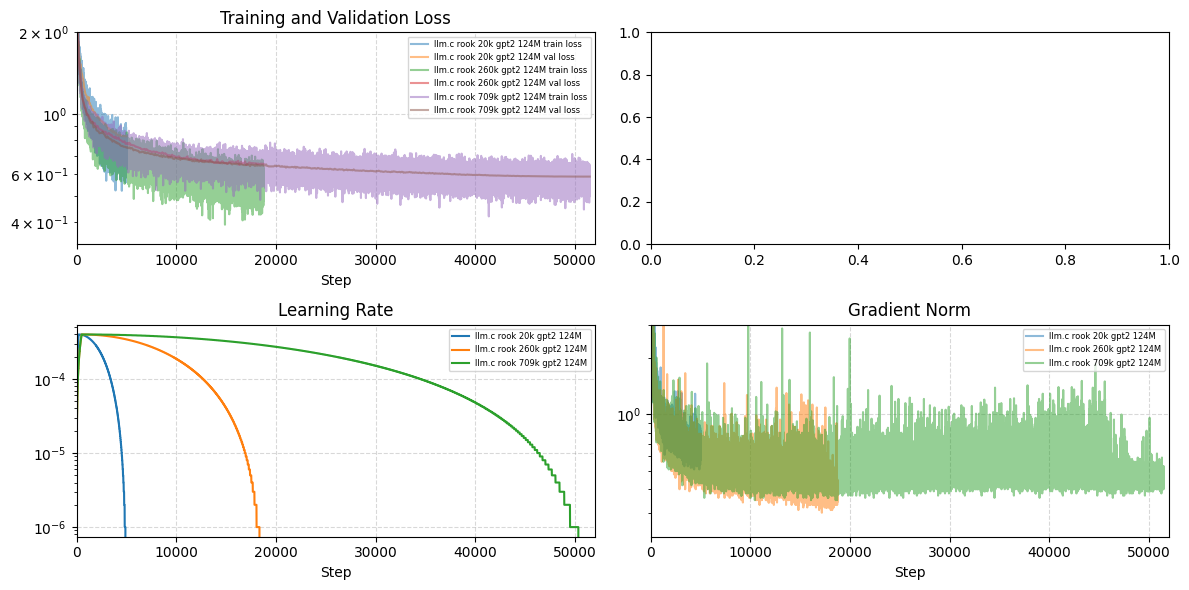

In [4]:
runs = [
    ("../log_gpt2_124M_rook/main.log", "llm.c rook 20k gpt2 124M"),
    ("../log_gpt2_124M_rook_260k/main.log", "llm.c rook 260k gpt2 124M"),
    ("../log_gpt2_124M_rook_709k/main.log", "llm.c rook 709k gpt2 124M"),
]
plot_logs(runs, sz="124M", max_steps=52_000, max_loss=2, max_norm=3.0)